In [1]:
import os
import sys

from transformers import MBartForConditionalGeneration, AutoTokenizer
import torch
from torch import nn
from tqdm import tqdm
import seaborn as sns
import numpy as np
import pandas as pd
import wandb
import html
import random

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.utils import resample

!pip install underthesea --quiet
from underthesea import word_tokenize

In [2]:
if torch.cuda.is_available():       
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [3]:
model = MBartForConditionalGeneration.from_pretrained("mc0c0z/BARTPho-multi-task")
tokenizer = AutoTokenizer.from_pretrained("mc0c0z/BARTPho-multi-task")
model.to(device)

config.json:   0%|          | 0.00/960 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/600M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/965 [00:00<?, ?B/s]

MBartForConditionalGeneration(
  (model): MBartModel(
    (shared): Embedding(64001, 768, padding_idx=1)
    (encoder): MBartEncoder(
      (embed_tokens): MBartScaledWordEmbedding(64001, 768, padding_idx=1)
      (embed_positions): MBartLearnedPositionalEmbedding(1026, 768)
      (layers): ModuleList(
        (0-5): 6 x MBartEncoderLayer(
          (self_attn): MBartAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): L

# Data Preparing

In [4]:
train_vlsp_2016 = pd.read_csv('/kaggle/input/vlsp-2016/train.csv')
train_aivivn_2019 = pd.read_csv('/kaggle/input/aivivn-2019/train.csv')

test_vlsp_2016 = pd.read_csv('/kaggle/input/vlsp-2016/test.csv')
test_aivivn_2019 = pd.read_csv('/kaggle/input/aivivn-2019/test.csv')

In [5]:
train_sa_data = pd.concat([train_aivivn_2019, train_vlsp_2016])
label_0 = train_sa_data[train_sa_data['label'] == 0]
label_1 = train_sa_data[train_sa_data['label'] == 1]

# Tính số lượng mẫu cho mỗi nhãn
n_samples = 20000 // 2

# Sample từ mỗi nhóm
sampled_0 = resample(label_0, n_samples=n_samples, replace=False, random_state=17)
sampled_1 = resample(label_1, n_samples=n_samples, replace=False, random_state=9)

# Kết hợp các mẫu đã lấy
balanced_sample = pd.concat([sampled_0, sampled_1])

# Xáo trộn dữ liệu
train_sa_data = balanced_sample.sample(frac=1, random_state=42).reset_index(drop=True)
train_sa_data = train_sa_data.drop(columns='id').rename(columns={'comment': 'source', 'label': 'target'})

# Chia dữ liệu train thành train:val = 90:10
train_sa_data, val_sa_data = train_test_split(train_sa_data, test_size=0.1, random_state=42)

test_vlsp_2016 = test_vlsp_2016.rename(columns={'comment': 'source', 'label': 'target'})
test_aivivn_2019 = test_aivivn_2019.rename(columns={'comment': 'source', 'label': 'target'})

In [6]:
vi_train_dataset = pd.read_csv("/kaggle/input/en-vi-small/train/train.vi", sep='\t', header=None)
en_train_dataset = pd.read_csv("/kaggle/input/en-vi-small/train/train.en", sep='\t', header=None)

vi_val_dataset = pd.read_csv("/kaggle/input/en-vi-small/val/tst2012.vi", sep='\t', header=None)
en_val_dataset = pd.read_csv("/kaggle/input/en-vi-small/val/tst2012.en", sep='\t', header=None)

vi_test_dataset = pd.read_csv("/kaggle/input/en-vi-small/test/tst2013.vi", sep='\t', header=None)
en_test_dataset = pd.read_csv("/kaggle/input/en-vi-small/test/tst2013.en", sep='\t', header=None)

# Limit train data to 10000 samples
# vi_train_dataset = vi_train_dataset.sample(n=10000, random_state=42).reset_index(drop=True)
# en_train_dataset = en_train_dataset.sample(n=10000, random_state=42).reset_index(drop=True)

# Limit val and test data to 1000 samples
vi_val_dataset = vi_val_dataset.sample(n=1000, random_state=42).reset_index(drop=True)
en_val_dataset = en_val_dataset.sample(n=1000, random_state=42).reset_index(drop=True)

vi_test_dataset = vi_test_dataset.sample(n=1000, random_state=42).reset_index(drop=True)
en_test_dataset = en_test_dataset.sample(n=1000, random_state=42).reset_index(drop=True)

In [7]:
# Tạo train_mt_data
train_mt_en_vi_data = pd.DataFrame({
    'source': en_train_dataset[0],
    'target': vi_train_dataset[0]
}).sample(n=15000, random_state=2)

train_mt_vi_en_data = pd.DataFrame({
    'source': vi_train_dataset[0],
    'target': en_train_dataset[0]
}).sample(n=15000, random_state=40)

# Tạo val_mt_data
val_mt_en_vi_data = pd.DataFrame({
    'source': en_val_dataset[0],
    'target': vi_val_dataset[0]
})

val_mt_vi_en_data = pd.DataFrame({
    'source': vi_val_dataset[0],
    'target': en_val_dataset[0]
})

# Tạo test_mt_data
test_mt_en_vi_data = pd.DataFrame({
    'source': en_test_dataset[0],
    'target': vi_test_dataset[0]
})

test_mt_vi_en_data = pd.DataFrame({
    'source': vi_test_dataset[0],
    'target': en_test_dataset[0]
})

In [8]:
# Thêm cột 'task' để phân biệt giữa SA và MT
train_sa_data['task'] = 'sa'
train_mt_en_vi_data['task'] = 'mt-en-vi'
train_mt_vi_en_data['task'] = 'mt-vi-en'

train_data = pd.concat([train_sa_data, train_mt_en_vi_data, train_mt_vi_en_data], ignore_index=True)
train_data = train_data.sample(frac=1, random_state=42).reset_index(drop=True)

val_sa_data['task'] = 'sa'
val_mt_en_vi_data['task'] = 'mt-en-vi'
val_mt_vi_en_data['task'] = 'mt-vi-en'

val_data = pd.concat([val_sa_data, val_mt_en_vi_data, val_mt_vi_en_data], ignore_index=True)
val_data = val_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Create Dataset

In [9]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, word_tokenize):
        self.tokenizer = tokenizer
        self.word_tokenize = word_tokenize
        self.data = dataframe
    
    def get_prompt(self, task):
        if task == 'sa':
            return "Classify the sentiment: "
        elif task == 'mt-en-vi':
            return "Translate English to Vietnamese: "
        elif task == 'mt-vi-en':
            return "Translate Vietnamese to English: "
        else:
            return "" 
        
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        task = row['task']
        prompt = self.get_prompt(task)
        
        tokenized_text = self.word_tokenize(str(row['source']))
        source = prompt + " ".join(tokenized_text)
        target = str(row['target'])

        sources = self.tokenizer(source, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
        targets = self.tokenizer(target, padding='max_length', truncation=True, max_length=128, return_tensors='pt')

        return {
            "input_ids": sources["input_ids"][0],
            "attention_mask": sources["attention_mask"][0],
            "labels": targets["input_ids"][0]
        }

    def __len__(self):
        return len(self.data)

In [10]:
def segmenter(text):
    text = html.unescape(text)
    tokens = word_tokenize(text)
    result = []
    for token in tokens:
        if ' ' in token:
            result.append(token.replace(' ', '_'))
        else:
            result.append(token)
    return result

In [11]:
# Create multi task dataset
train_dataset = CustomDataset(train_data, tokenizer, segmenter)
val_dataset = CustomDataset(val_data, tokenizer, segmenter)

# Training

In [ ]:
from kaggle_secrets import UserSecretsClient

# Tự động nhập API key từ Kaggle Secret
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb_api_key")
wandb.login(key=secret_value_0)

# # Đặt cấu hình cho wandb
wandb.init(project="BTL NLP BERT", name="BARTPho SA+MT2 next")

In [ ]:
from transformers import Trainer, TrainingArguments

# Training parameters
training_args = TrainingArguments(
    output_dir='./results',
    run_name="BARTPho_finetuning_SA+MT2",
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=237,
    eval_strategy="epoch",
    save_strategy="no",
    report_to="wandb",
    gradient_accumulation_steps=5,
    learning_rate=3e-5,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
)

In [ ]:
torch.cuda.empty_cache()
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'

# Train the model
trainer.train()

# Upload model to huggingface

In [ ]:
secret_value_1 = user_secrets.get_secret("huggingface_token")
!huggingface-cli login --token $secret_value_1 --add-to-git-credential

In [ ]:
model.push_to_hub("mc0c0z/BARTPho-multi-task")
tokenizer.push_to_hub("mc0c0z/BARTPho-multi-task")

# Testing

In [12]:
def inference(prompt, text, device):
    text = prompt + " ".join(segmenter(text))
    inputs = tokenizer(text, max_length=128, truncation=True, return_tensors="pt").input_ids.to(device)
    preds = model.generate(inputs, max_length=128, num_beams=1)
    decoded_preds = tokenizer.batch_decode(sequences=preds, skip_special_tokens=True)

    return decoded_preds

prompt = {
    'sa': 'Classify the sentiment: ',
    'mt-en-vi': 'Translate English to Vietnamese: ',
    'mt-vi-en': 'Translate Vietnamese to English: '
}
print(inference(prompt['sa'], "This movie is bad.", device))
print(inference(prompt['mt-en-vi'], "This movie is bad.", device))
print(inference(prompt['mt-vi-en'], "Bộ phim này tệ.", device))

['0']
['Đoạn phim này thật tệ.']
['This film was a bad.']


In [13]:
def generate_predictions(model, dataset, device, batch_size=32):
    model.eval()
    predictions = []
    targets = []
    inputs = []
    
    # Tạo DataLoader
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    with torch.no_grad():
        for batch in tqdm(dataloader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            generated_outputs = model.generate(input_ids, attention_mask=attention_mask, max_length=128)
            batch_predictions = tokenizer.batch_decode(generated_outputs, skip_special_tokens=True)
            
            batch_targets = tokenizer.batch_decode(batch['labels'], skip_special_tokens=True)
            
            predictions.extend(batch_predictions)
            targets.extend(batch_targets)
            inputs.extend(input_ids.tolist())
    
    return inputs, targets, predictions

In [14]:
test_vlsp_2016 = test_vlsp_2016[test_vlsp_2016['target'] != 2]
test_vlsp_2016.loc[:, 'task'] = 'sa'
test_aivivn_2019.loc[:, 'task'] = 'sa'

# Tạo dataloader cho tập test VLSP 2016
test_vlsp_2016_dataloader = CustomDataset(test_vlsp_2016, tokenizer, segmenter)
test_aivivn_2019_dataloader = CustomDataset(test_aivivn_2019, tokenizer, segmenter)

100%|██████████| 746/746 [01:54<00:00,  6.53it/s]


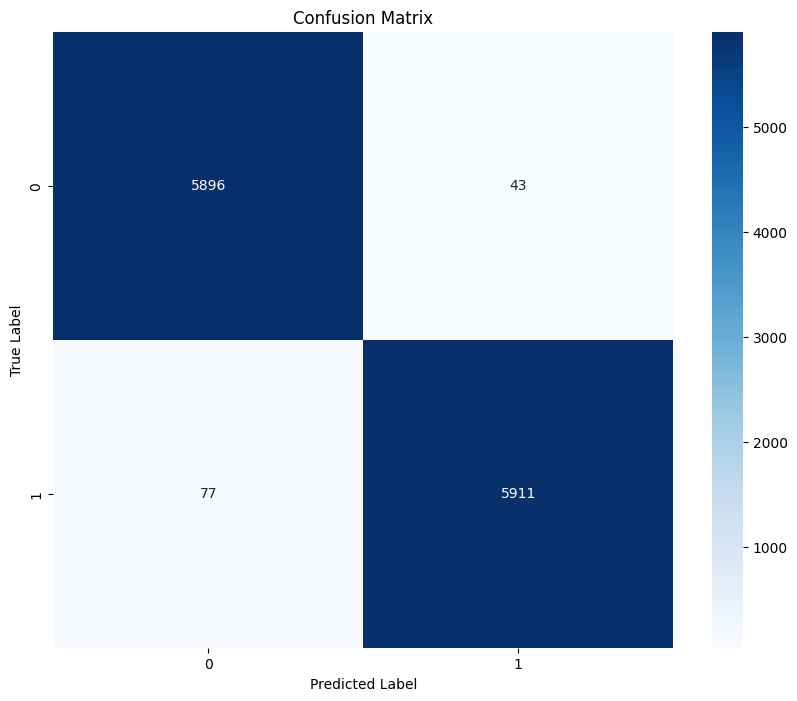

Classification Report:
              precision    recall  f1-score   support

           0     0.9871    0.9928    0.9899      5939
           1     0.9928    0.9871    0.9900      5988

    accuracy                         0.9899     11927
   macro avg     0.9899    0.9900    0.9899     11927
weighted avg     0.9900    0.9899    0.9899     11927



In [15]:
def report_sa_task(targets, predictions):
    # Chuyển đổi nhãn từ chuỗi sang số
    label_map = {'0': 0, '1': 1, '2': 2}
    predictions = [label_map.get(p[0], -1) if p else -1 for p in predictions]  # -1 cho các giá trị không hợp lệ
    true_labels = [label_map.get(t, -1) for t in targets]
    
    # Loại bỏ các cặp dự đoán và nhãn không hợp lệ
    valid_pairs = [(p, t) for p, t in zip(predictions, true_labels) if p != -1 or t != -1]
    if valid_pairs:
        predictions, true_labels = zip(*valid_pairs)
    else:
        print("Không có dự đoán hợp lệ nào.")
        return
    
    # Tạo confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    unique_labels = sorted(set(true_labels + predictions))
    # Vẽ heatmap cho confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=unique_labels, yticklabels=unique_labels)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # In ra classification report
    report = classification_report(true_labels, predictions, digits=4)
    print("Classification Report:")
    print(report)

_, targets, predictions = generate_predictions(model, test_vlsp_2016_dataloader, device, batch_size=16)
report_sa_task(targets, predictions)

100%|██████████| 202/202 [00:28<00:00,  7.08it/s]


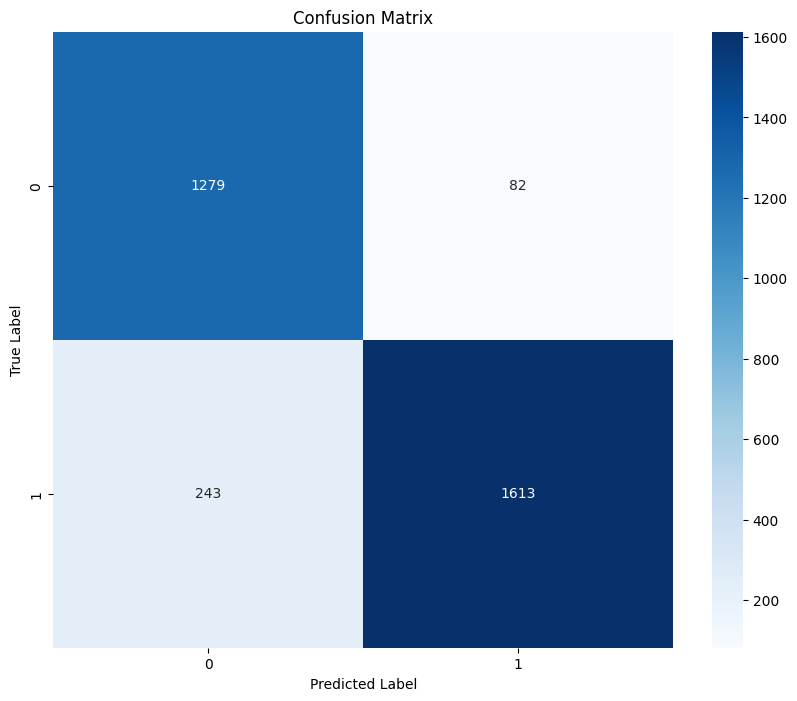

Classification Report:
              precision    recall  f1-score   support

           0     0.8403    0.9398    0.8873      1361
           1     0.9516    0.8691    0.9085      1856

    accuracy                         0.8990      3217
   macro avg     0.8960    0.9044    0.8979      3217
weighted avg     0.9045    0.8990    0.8995      3217



In [16]:
_, targets, predictions = generate_predictions(model, test_aivivn_2019_dataloader, device, batch_size=16)
report_sa_task(targets, predictions)

In [17]:
test_mt_en_vi_data['task'] = 'mt-en-vi' 
test_mt_vi_en_data['task'] = 'mt-vi-en' 
test_mt_en_vi_dataloader = CustomDataset(test_mt_en_vi_data, tokenizer, segmenter)
inputs, targets, predictions = generate_predictions(model, test_mt_en_vi_dataloader, device, batch_size=16)

100%|██████████| 63/63 [00:36<00:00,  1.75it/s]


In [18]:
from nltk.translate.bleu_score import sentence_bleu
from nltk import word_tokenize

print("\nMột số kết quả:")
random_samples = random.sample(list(zip(inputs, targets, predictions)), 10)

for input_ids, true_label, pred_label in random_samples:
    print(f"Input: {tokenizer.decode(input_ids, skip_special_tokens=True)}")
    print(f"Target: {true_label}")
    print(f"Prediction: {pred_label}")
    # Tính BLEU Score
    reference = word_tokenize(true_label)
    hypothesis = word_tokenize(pred_label)
    bleu_score = sentence_bleu([reference], hypothesis)
    print(f"BLEU Score: {bleu_score:.4f}")
    print("-" * 50)

2024-08-01 16:26:21.309924: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered



Một số kết quả:


2024-08-01 16:26:21.310041: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-01 16:26:21.447340: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Input: Translate English to Vietnamese: My next invention is, I want to make_an electric fence. Electric fence?
Target: Phát minh sắp tới của cháu, cháu muốn làm một hàng rào điện. Hàng rào điện sao?
Prediction: Việc tiếp theo của tôi là, tôi muốn tạo ra một vòng điện hoá. Vòng điện hoá học là gì?
BLEU Score: 0.7680
--------------------------------------------------
Input: Translate English to Vietnamese: Instead, this example slide by Genevieve Brown is much more effective. It's showing that the special structure of_trabeculae are so strong that they actually inspired the unique design of_the Eiffel_Tower.
Target: Thay vào đó, slide ví dụ này của Genevieve Brown thực sự hiểu quả hơn. Nó cho thấy cấu trúc đặc biệt của mô xương mạnh đến nỗi nó thực sự truyền cảm hứng cho thiết kế độc đáo của tháp Ép-phen.
Prediction: Thay vào đó, biểu đồ này của Genevieve Brown có hiệu quả hơn nhiều. Nó cho thấy cấu trúc đặc biệt của các tế bào thần kinh là rất mạnh khi họ thực sự đã giới thiệu thiết kế

/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [19]:
from nltk.translate.bleu_score import corpus_bleu
from nltk import word_tokenize

def calculate_bleu(references, hypotheses):
    references_tokenized = [[word_tokenize(ref)] for ref in references]
    hypotheses_tokenized = [word_tokenize(hyp) for hyp in hypotheses]
    return corpus_bleu(references_tokenized, hypotheses_tokenized)
bleu_score = calculate_bleu(targets, predictions)
print(f'BLEU-4 Eng-Vie Score: {bleu_score * 100:.2f}')

BLEU-4 Eng-Vie Score: 20.99


In [20]:
test_mt_vi_en_dataloader = CustomDataset(test_mt_vi_en_data, tokenizer, segmenter)
inputs, targets, predictions = generate_predictions(model, test_mt_vi_en_dataloader, device, batch_size=16)

100%|██████████| 63/63 [00:46<00:00,  1.36it/s]


In [21]:
from nltk.translate.bleu_score import sentence_bleu
from nltk import word_tokenize

print("\nMột số kết quả:")
random_samples = random.sample(list(zip(inputs, targets, predictions)), 10)

for input_ids, true_label, pred_label in random_samples:
    print(f"Input: {tokenizer.decode(input_ids, skip_special_tokens=True)}")
    print(f"Target: {true_label}")
    print(f"Prediction: {pred_label}")
    # Tính BLEU Score
    reference = word_tokenize(true_label)
    hypothesis = word_tokenize(pred_label)
    bleu_score = sentence_bleu([reference], hypothesis)
    print(f"BLEU Score: {bleu_score:.4f}")
    print("-" * 50)


Một số kết quả:
Input: Translate Vietnamese to English: Bạn không thể nào bị sỉ nhục tồi tệ hơn thế, và đó là những lời từ Charles Darwin.
Target: You could not get a worse insult, and that from Charles Darwin.
Prediction: You don &apos;t have a bad guy in which is a bad guy, and that &apos;s the word Charles Darwin.
BLEU Score: 0.2389
--------------------------------------------------
Input: Translate Vietnamese to English: Bạn nên nhìn vào cái thứ vớ vẩn -- -- Bạn nên nhìn vào cái thứ vớ vẩn mà chúng ta đã ban cho những người dân Châu Phi không mảy may nghi ngờ.
Target: You should see the rubbish — -- You should see the rubbish that we have bestowed on unsuspecting African people.
Prediction: You should look at the vegetary -- you should look at the vegetary that they &apos;ve got for the Châu Phi unbelievable people.
BLEU Score: 0.4002
--------------------------------------------------
Input: Translate Vietnamese to English: Và khi chúng ta làm việc đó, ai mà biết được?
Target: And

In [22]:
bleu_score = calculate_bleu(targets, predictions)
print(f'BLEU-4 Vie-Eng Score: {bleu_score * 100:.2f}')

BLEU-4 Vie-Eng Score: 16.69
